In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
import logging

logger = logging.getLogger(__name__)

os.chdir("../")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from src.etl import *
from src.rfm import *
from src.utils import *

In [4]:
url = "https://www.gutenberg.org/cache/epub/1533/pg1533-images.html"

make_dataset(url)

Dataset already downloaded: download_log -> 6157ee4b54ae1a9c39fa52c057f5dfbd80554c634644ba4fc805528bf36a68f7


False

In [5]:
X, vocab = tokenizer("./data/Author: William Shakespeare.txt")

In [6]:
X.shape

(853, 32, 64)

In [7]:
data = X.reshape(X.shape[0], X.shape[1]*X.shape[2])

In [8]:
data.shape

(853, 2048)

In [9]:
vocab

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 'A': 27,
 'B': 28,
 'C': 29,
 'D': 30,
 'E': 31,
 'F': 32,
 'G': 33,
 'H': 34,
 'I': 35,
 'J': 36,
 'K': 37,
 'L': 38,
 'M': 39,
 'N': 40,
 'O': 41,
 'P': 42,
 'Q': 43,
 'R': 44,
 'S': 45,
 'T': 46,
 'U': 47,
 'V': 48,
 'W': 49,
 'X': 50,
 'Y': 51,
 'Z': 52,
 '.': 53,
 ',': 54,
 '!': 55,
 '?': 56,
 "'": 57,
 ':': 58,
 ';': 59,
 '-': 60,
 '_': 61,
 ' ': 0,
 '[PAD]': 62,
 '[UNK]': 63}

## Baseline: Bigrams/Trigrams

In [10]:
from nltk.util import bigrams, trigrams, pad_sequence
from nltk.lm.preprocessing import padded_everygram_pipeline, flatten
from nltk.lm import MLE

In [11]:
CONTEXT_SIZE = 32
TEST_SPLIT = 0.2

In [12]:
def clean_sentence(sent):
    # remove newline and separate into characters
    sent = list(sent[:-1])
    # add start token and truncate to context size
    sent = (["<START>"] + sent)[:CONTEXT_SIZE]
    # pad to context size
    if len(sent) == CONTEXT_SIZE:
        return sent
    elif len(sent) < CONTEXT_SIZE:
        # add end token
        sent = sent + ["<END>"]
        return sent + ["<PAD>"] * (CONTEXT_SIZE - len(sent))
    else:
        raise ValueError("Sentence too long after truncating. Something went wrong.")


In [13]:
# get the text

fpath = "./data/Author: William Shakespeare.txt"
raw = open(fpath, "r").readlines()
sentences = list(map(clean_sentence, raw))
train_sentences = sentences[:int(len(sentences) * (1 - TEST_SPLIT))]
test_sentences = sentences[int(len(sentences) * (1 - TEST_SPLIT)):]
len(train_sentences)

682

In [14]:
np.array(train_sentences)[:, :16].shape

(682, 16)

In [15]:
# shop the dataset in half. The first half will be used to condition the second half
CONTEXT_SPLIT_SIZE = 16
X_train = np.array(train_sentences)[:, :16]
y_train = np.array(train_sentences)[:, 16:]
X_test = np.array(test_sentences)[:, :16]
y_test = np.array(test_sentences)[:, 16:]

In [16]:
# get ngrams
ngrams = []
for sent in X_train:
    ngrams.append(list(bigrams(sent)))


In [17]:
# pad the text
vocab = list(flatten(sent for sent in X_train))

In [18]:
lm = MLE(3)
lm.fit(ngrams, vocab)

In [19]:
X_train[1]

array(['<START>', 'A', 'u', 't', 'h', 'o', 'r', ':', ' ', 'W', 'i', 'l',
       'l', 'i', 'a', 'm'], dtype='<U7')

In [20]:
def generate_text(lm, X_test, length=16):
    # generate text
    text = []
    for sent in X_test:
        text.append(lm.generate(length, text_seed=sent))
    return text

In [21]:
y_test.shape

(171, 16)

In [22]:
y_test_pred = np.array(generate_text(lm, X_test))

In [23]:
"".join(y_test[0]), "".join(y_test_pred[0])

(' the whetstone o', ' f helot’euo.Ano')

In [24]:
lm.vocab.unk_label

'<UNK>'

In [25]:
class Vocab():
    def __init__(self, vals):
        self._dict = {v: i for i, v in enumerate(vals)}
        self._dict['<UNK>'] = len(self._dict)
        self.rev = {i: v for v, i in self._dict.items()}
    
    def __getitem__(self, key):
        if key in self._dict:
            return self._dict[key]
        else:
            return self._dict['<UNK>']
    
    def __len__(self):
        return len(self._dict)
    
    def __iter__(self):
        return iter(self._dict)
    
    def __contains__(self, key):
        return key in self._dict
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self._dict})"
    
    def decode(self, idx):
        return self.rev[idx]

In [26]:
train_vocab = Vocab(list(sorted(lm.vocab.counts.keys())))
train_vocab

Vocab({' ': 0, '!': 1, ',': 2, '-': 3, '.': 4, ':': 5, ';': 6, '<END>': 7, '<PAD>': 8, '<START>': 9, '?': 10, 'A': 11, 'B': 12, 'C': 13, 'D': 14, 'E': 15, 'F': 16, 'G': 17, 'H': 18, 'I': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, '[': 35, ']': 36, 'a': 37, 'b': 38, 'c': 39, 'd': 40, 'e': 41, 'f': 42, 'g': 43, 'h': 44, 'i': 45, 'j': 46, 'k': 47, 'l': 48, 'm': 49, 'n': 50, 'o': 51, 'p': 52, 'q': 53, 'r': 54, 's': 55, 't': 56, 'u': 57, 'v': 58, 'w': 59, 'x': 60, 'y': 61, '—': 62, '’': 63, '“': 64, '<UNK>': 65})

In [27]:
def encode(sent, vocab=train_vocab):
    return np.array([vocab[w] for w in sent])

def evaluate(y_test, y_test_pred):
    # evaluate
    bleu = []
    perplexity = []
    y_perplexity = []
    for i in range(len(y_test)):
        bleu.append(utils.bleu_score([y_test[i]], y_test_pred[i], n=2))
        perplexity.append(utils.perplexity(encode(y_test_pred[i])))
        y_perplexity.append(utils.perplexity(encode(y_test[i])))
    return { "bleu2": np.mean(bleu), "perplexity": np.mean(perplexity), "true_perplexity": np.mean(y_perplexity) }

In [28]:
list(map(lambda x: "".join(x), y_test_pred))

[' f helot’euo.Ano',
 ' d MALCDUFF.Ther',
 'rrendo o MACDUF.',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'is seror irr ng ',
 'ertl vet.Thaleco',
 'nfe’lit f MACDri',
 'whielorin, d Wiv',
 'cked, ROSer WITH',
 'd ouds but bthy ',
 'shit y Madicenk ',
 'er lod ar he hyr',
 'e, ceritoth.LACO',
 'teuoue: mapllanq',
 ' he?<END><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 ' fitet d y M.’y ',
 ' meathe kes iean',
 'MALathinee, cas,',
 'WIRSECH.]<END><PAD><PAD><PAD><PAD><PAD><PAD>',
 'rvare, blllou Kn',
 'okeud il;—R.Shin',
 'ntew m-beteplll ',
 'y, MACBETir ary ',
 'abllllin BEThend',
 'hinqumal MACORD ',
 'rth wigacok! han',
 '’le ERERend ntel',
 'outand Wher muf.',
 'e MADURD.Whierer',
 'no IRDY berst.WI',
 'cofure blang We ',
 's hasent, MACDY ',
 'buend.NN.BEnt ks',
 '<END><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>

In [29]:
evaluate(y_test, y_test_pred)

/home/arunavgupta/anaconda3/envs/huggingface/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


{'bleu2': 0.20626770992708185,
 'perplexity': 12.797222003982853,
 'true_perplexity': 12.526818139778857}

## Laplacian Kernel

In [30]:
# replace each token with its index in the vocab
X_train_enc = np.array([encode(sent) for sent in X_train])
y_train_enc = np.array([encode(sent) for sent in y_train])
X_test_enc = np.array([encode(sent) for sent in X_test])
y_test_enc = np.array([encode(sent) for sent in y_test])

In [31]:
# one hot encode the data
X_train_enc = np.eye(len(train_vocab))[X_train_enc]
X_train_enc = X_train_enc.reshape(X_train_enc.shape[0], X_train_enc.shape[1]*X_train_enc.shape[2])
y_train_enc = np.eye(len(train_vocab))[y_train_enc]
y_train_enc = y_train_enc.reshape(y_train_enc.shape[0], y_train_enc.shape[1]*y_train_enc.shape[2])
X_test_enc = np.eye(len(train_vocab))[X_test_enc]
X_test_enc = X_test_enc.reshape(X_test_enc.shape[0], X_test_enc.shape[1]*X_test_enc.shape[2])
y_test_enc = np.eye(len(train_vocab))[y_test_enc]
y_test_enc = y_test_enc.reshape(y_test_enc.shape[0], y_test_enc.shape[1]*y_test_enc.shape[2])

In [32]:
from functools import partial

In [33]:
next_char_train = y_train_enc[:, :len(train_vocab)]
next_char_test = y_test_enc[:, :len(train_vocab)]

In [34]:
# train a laplace kernel
lam = 1
kernel = partial(utils.K_laplace_mat, gamma=0.025)

K = kernel(X_train_enc, X_train_enc)
alpha_hat = np.linalg.solve(K + lam * np.eye(K.shape[0]), next_char_train)

In [35]:
yhat = kernel(X_test_enc, X_train_enc) @ alpha_hat
yhat

array([[ 2.68798410e-01,  0.00000000e+00,  3.57026525e-02, ...,
         3.18385549e-02,  0.00000000e+00,  0.00000000e+00],
       [ 8.03665828e-02,  0.00000000e+00, -2.04314102e-02, ...,
        -7.94758610e-03,  0.00000000e+00,  0.00000000e+00],
       [ 2.38647201e-01,  0.00000000e+00,  5.66607509e-03, ...,
        -1.67007651e-02,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 5.27604748e-02,  0.00000000e+00,  7.56617279e-03, ...,
        -1.09487379e-02,  0.00000000e+00,  0.00000000e+00],
       [ 2.81853396e-01,  0.00000000e+00,  2.82378089e-02, ...,
         2.85882678e-02,  0.00000000e+00,  0.00000000e+00],
       [ 6.63803125e-02,  0.00000000e+00, -1.34030998e-02, ...,
         9.72784103e-05,  0.00000000e+00,  0.00000000e+00]])

In [36]:
(next_char_test.argmax(axis=1) == yhat.argmax(axis=1)).mean()

0.30994152046783624

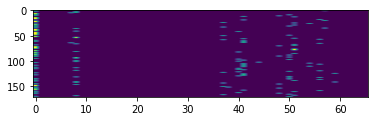

In [37]:
max_index = np.argmax(yhat, axis=1)
yhat[np.arange(yhat.shape[0]), max_index] = 1
yhat[yhat != 1] = 0
plt.imshow(yhat, aspect=0.1)

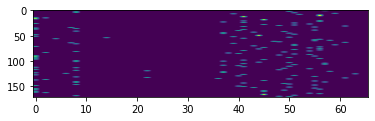

In [38]:
# plot next_char_train, with a good aspect ratio
plt.imshow(next_char_test, aspect=0.1)

In [39]:
yhat_train = kernel(X_train_enc, X_train_enc) @ alpha_hat

(next_char_train.argmax(axis=1) == yhat_train.argmax(axis=1)).mean()

0.8123167155425219

In [40]:
def generate_text_kernel(kernel, alpha_hat, X, z, length=16):
    text = []
    for i in range(length):
        yhat = kernel(X, z) @ alpha_hat
        # decode the text
        text.append([train_vocab.decode(y) for y in np.argmax(yhat, axis=1)])
        # move the window forward
        X = np.concatenate([X[:, len(train_vocab):], yhat], axis=1)
    
    transpose = list(zip(*text))
    return transpose

In [41]:
generated_test = generate_text_kernel(kernel, alpha_hat, X_test_enc, X_train_enc, length=16)

In [42]:
list(map(lambda x: "".join(x), generated_test))

['    t  n  <PAD><PAD><PAD>  <PAD>',
 'ue      o    <PAD><PAD> ',
 '    n  ote  <PAD>  <PAD>',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 '<END>o<PAD> e e  <PAD> e<PAD> <PAD><PAD>',
 ' ed  e r d<PAD>  <PAD><PAD><PAD>',
 '  o  t   e   <PAD><PAD><PAD>',
 ' endoet <PAD>o e   <PAD>',
 'nd  ot      t   ',
 ' oedeo eoo e   <PAD>',
 'l  o    t <PAD><PAD> <PAD><PAD><PAD>',
 'eee <PAD><PAD>  o<PAD><PAD> <PAD><PAD> <PAD>',
 'od  t n  et <PAD><PAD><PAD><PAD>',
 '  t o  oo<PAD> <PAD><PAD> <PAD><PAD>',
 ' <PAD>  <PAD>e         <PAD>',
 '  a    e <PAD><PAD>  <PAD><PAD><PAD>',
 '  o  oe  e      ',
 'to   orde. e  <PAD><PAD>',
 'eeet e   <PAD> e  <PAD><PAD>',
 'uete     <PAD> <PAD><PAD><PAD><PAD><PAD>',
 ' s  o n  et     ',
 '   s           <PAD>',
 ' ed  aeo  e   <PAD><PAD>',
 'ant          <PAD>  ',
 'o   oa o  e   <PAD><PAD>',
 'rd  ot   t <PAD><PAD> <PAD><PAD>',
 ' ete   

In [43]:
evaluate(y_test, generated_test)

{'bleu2': 0.21372329023610848,
 'perplexity': 6.919622905476647,
 'true_perplexity': 12.526818139778857}

## RFM

In [44]:
alpha, M, _ = train_rfm(X_train_enc, next_char_train)

/home/arunavgupta/Documents/UCSD/ml-theory-capstone/src/utils.py:103: RuntimeWarning: divide by zero encountered in true_divide
  K = K / dist


In [45]:
y_train_pred = utils.K_M(X_train_enc, X_train_enc, M, L=1.0) @ alpha

In [46]:
utils.mse(y_train_pred, next_char_train)


0.0009125162458599272

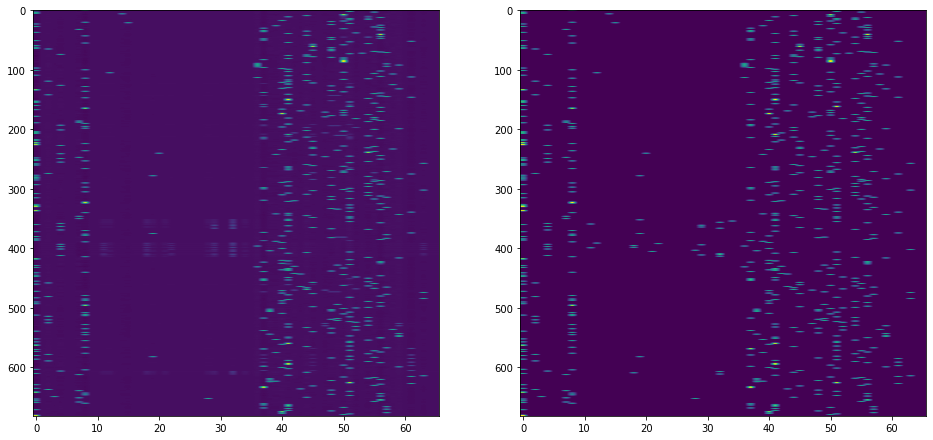

In [47]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
ar = (y_train_pred.shape[1]/y_train_pred.shape[0])
ax[0].imshow(utils.softmax(y_train_pred, axis=1), aspect=ar)
ax[1].imshow(next_char_train, aspect=ar)

In [48]:
y_test_pred = utils.K_M(X_test_enc, X_train_enc, M, L=1.0) @ alpha

In [49]:
utils.mse(y_test_pred, next_char_test)

0.014336522288874193

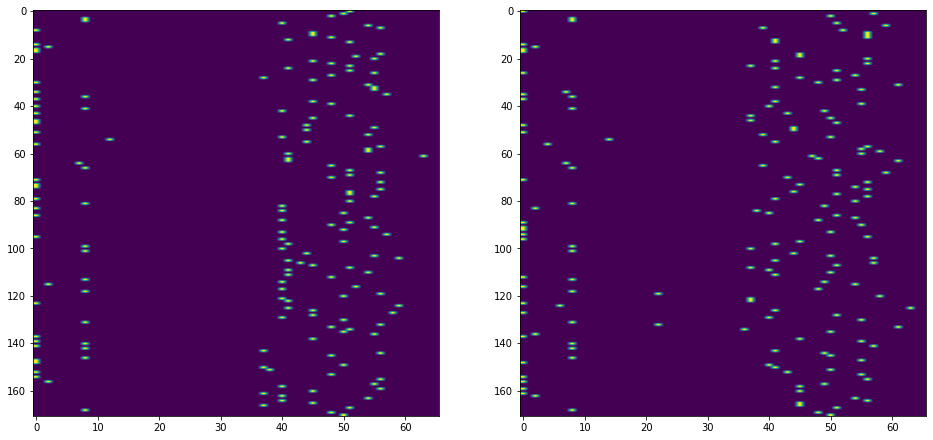

In [50]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
ar = (y_test_pred.shape[1]/y_test_pred.shape[0])
y_test_argmax_ohc = np.eye(len(train_vocab))[y_test_pred.argmax(axis=1)]
ax[0].imshow(y_test_argmax_ohc, aspect=ar)
ax[1].imshow(next_char_test, aspect=ar)

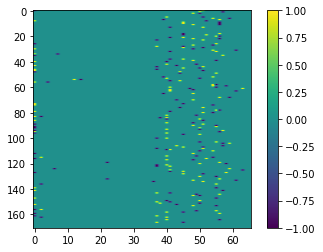

In [51]:
plt.imshow(y_test_argmax_ohc - next_char_test, aspect=ar)
plt.colorbar()

In [52]:
from functools import partial

In [53]:
kernel_rfm = partial(utils.K_M, M=M, L=1.0)

gen_test_rfm = generate_text_kernel(kernel_rfm, alpha, X_test_enc, X_train_enc, length=16)

In [54]:
evaluate(y_test, gen_test_rfm)

{'bleu2': 0.1967504710992221,
 'perplexity': 12.090794674243803,
 'true_perplexity': 12.526818139778857}

In [59]:
list(map(lambda x: "".join(x), gen_test_rfm))

['ooe i De veDe ho',
 'nntrere hocc er ',
 'ls ti pone woc, ',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'douqere th eoDtD',
 'riy  te.<END>eer ioc',
 't eo the toe .oD',
 ' endter houc oe ',
 'iditond hoc, wo ',
 'ioeduo eo] Do.yh',
 'l toev te poue h',
 'eteris  oo  oD f',
 'oc<END> son<END> io v er',
 ' poip vochoee po',
 ', ioet eekteDe p',
 ' ianc oe pote po',
 ' dond ee ioce pr',
 'toes oo pout poc',
 'peet te sore poc',
 'seth ih.v t eec ',
 'is  kocdoerheDe ',
 'l  nq houv hecvo',
 'oekthee, vecc ir',
 'eit veDv Io doee',
 'oes or h.De peDt',
 'sd toud rerp te ',
 'lerit. yoDt te t',
 'anv sond oo poee',
 'ik, qe t ie .o<END>v',
 ' wo<END>e hoce pe h ',
 'r’i ooes heec te',
 'st, soon ooch ee',
 'sees ioDv tr eot',
 '  o tert Dh po v',
 'uith  wiev teep ',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 ' do pn<EN

In [57]:
# get train and test accuracy
train_acc = (next_char_train.argmax(axis=1) == y_train_pred.argmax(axis=1)).mean()
test_acc = (next_char_test.argmax(axis=1) == y_test_pred.argmax(axis=1)).mean()

print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

Train accuracy: 0.95
Test accuracy: 0.31
